## Initialize python imports, notebook window width,  and graphics window position
Executed automatically on start or restart.

In [1]:
%gui osx
import random as rand
import numpy as np
import genelife as g

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

# 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))     # sets input cells to use full window width

from os import environ
environ['SDL_VIDEO_WINDOW_POS'] = "%d,%d" % (1000,32)   # set position of pygame (SDL) video window (x,y) pixel coords, values work well on iMac

from bayespy.nodes import Categorical, Dirichlet
from bayespy.nodes import Beta
from bayespy.nodes import Mixture, Bernoulli
from bayespy.inference import VB  # variational Bayes inference engine
import bayespy.plot as bpplt

Running with SDL version 2.0.9.


## Selection 11 Distance distinguishing LUT encoded by gene with variable length encoding

In [2]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 19 cases s=2-6 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 19 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x0610        # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0xffff
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000001e0 # for selection=10-13 this is the GoL birth mask
g.birthmask    = g.runparams[7] = 0x000001e2 # for selection=10-13 this is the GoL birth mask
g.birthmask    = g.runparams[7] = 0x000001e2 # for selection=10-13 this is the GoL birth mask
g.birthmask    = g.runparams[4] = 0x0 # for selection=10-11 this is the GoL survival mask
g.birthmask    = g.runparams[4] = 0x007fffff # for selection=10-11 this is the GoL survival mask
g.survivalmask = g.runparams[4] = 0x000001fc # for selection=10-11 this is the GoL survival mask
g.survivalmask = g.runparams[4] = 0x00000 # for selection=10-11 this is the GoL survival mask
g.survivalmask = g.runparams[4] = 0x007fffff # for selection=10-11 this is the GoL survival mask



g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 1               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.set_seed(2)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

/Users/n/Projects/genelife/fastgenegol/genelifepy/genelife.py:403: ExperimentalWarning: 'pixels2d' is in an experimental state.
  cgrid=sdl2.ext.pixels2d(surface)


## get gene data

In [3]:
maxngenes = 2000000
# genedtype=[('popcount',c_uint32),('firsttime',c_uint32),('lasttime',c_uint32),('lastextinctiontime',c_int32),    #    3 unsigned 1 signed int 32 bits
#            ('activity',c_uint32),('nextinctions',c_uint32),('gene',c_uint64),('firstancestor',c_uint64)]         #    2 unsigned 32 bit and 2 unsigned 64 bit int
genelist = np.zeros(maxngenes,dtype=g.genelife.genedtype)
ngenes=g.genelife.get_genes(genelist)
# print(g.genelife.genedtype)
print('ngenes',ngenes)
print('      gene        firstancestor   popcount  firsttime lasttime lastextinctiontime nextinctions activity')
curtime = g.genelife.get_curtime()
for i in range(200):
    if genelist[i]['lasttime'] == curtime:
        foo = "%16x %16x %8d %8d %8d %14d %12d %14d" % \
        (genelist[i]['gene'], genelist[i]['firstancestor'], genelist[i]['popcount'],genelist[i]['firsttime'], genelist[i]['lasttime'],
         genelist[i]['lastextinctiontime'], genelist[i]['nextinctions'], genelist[i]['activity'] )
        print(foo)

ngenes 4903
      gene        firstancestor   popcount  firsttime lasttime lastextinctiontime nextinctions activity
          bf3f27 fedcba9876543210      452        0      347             -1            0         111377
 280000000bf3f27  200000000bf3f27       79       10      347             -1            0          33736
4000000000bf3f27           bf3f27        1       24      347            282            5           1895
9000400000bf3f27 1000400000bf3f27       26       39      347             44            2           3176
4004000000bf3f27 4000000000bf3f27       33       78      347             -1            0          32737


In [4]:
ngenes

4903

In [5]:
glive = [genelist[i] for i in range(len(genelist)) if genelist[i]['lasttime']==curtime]

In [6]:
len(glive)

1016

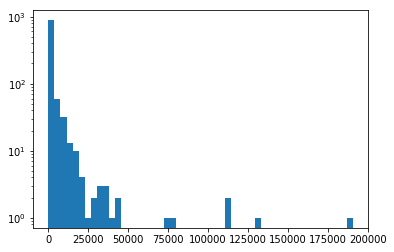

In [7]:
act = [glive[i]['activity'] for i in range(len(glive))]
plt.yscale('log', nonposy='clip')
plt.hist(act,bins=50);

In [8]:
gg = [glive[i]['gene'] for i in range(len(glive))]

In [9]:
genes = [gg['gene'] for gg in glive]

## get genealogy data

In [14]:
gdepth = g.genelife.get_genealogydepth()
nspecies = g.genelife.get_nspecies()
gdat = np.zeros((gdepth+1)*nspecies,dtype=g.genelife.c_uint64)
mxdepth = g.genelife.get_genealogies(gdat)

In [15]:
(gdepth+1)*nspecies

18672

In [16]:
gdat.shape = (nspecies,mxdepth+1)

In [17]:
gdat = [[x for x in gdat[i] if x!= 0xfedcba9876543210] for i in range(len(gdat))]

In [18]:
[[hex(x) for x in gdat[i]] for i in range(10)]

[['0x0', '0x0'],
 ['0xbf3f27', '0x0', '0x200000000bf3f27'],
 ['0xbf3f27', '0x0', '0xbf3f27'],
 ['0x0', '0x1000400000bf3f27', '0x1000000000bf3f27', '0xbf3f27'],
 ['0x0', '0x4000000000bf3f27', '0xbf3f27'],
 ['0x0', '0x280000000bf3f27', '0x200000000bf3f27', '0xbf3f27'],
 ['0x0', '0x80000000bf3f27', '0xbf3f27'],
 ['0x0',
  '0x40100400bf3f27',
  '0x40100000bf3f27',
  '0x40000000bf3f27',
  '0xbf3f27'],
 ['0x0', '0x8800000000bf3f27', '0x8000000000bf3f27', '0xbf3f27'],
 ['0x0',
  '0x4900400011bf3f27',
  '0x4100400011bf3f27',
  '0x4100400001bf3f27',
  '0x100400001bf3f27',
  '0x100000001bf3f27',
  '0x1bf3f27',
  '0xbf3f27']]

In [33]:
gdat = gdat[1:]

In [36]:
len([i for i in range(len(gdat)) if len(gdat[i])==0])

67

In [37]:
heads = [gdat[i][0] for i in range(len(gdat)) if len(gdat[i])>0]
tails = [gdat[i][len(gdat[i])-1] for i in range(len(gdat)) if len(gdat[i])>0]

In [47]:
sum([heads[i] in genes for i in range(len(heads))])

1016

In [48]:
len(set(heads))

1167

In [11]:
bdat = [bin(dat[i]) for i in range(len(dat))]
ldat = [[int(x) for x in bdat[i][2:]] for i in range(len(bdat))]

# pad front end with zeros
lldat = [[0 for _ in range(64-len(ldat[i]))]+ldat[i] for i in range(len(ldat))]

len(lldat)

In [13]:
for i in range(10):
    print(len(ldat[i]),ldat[i])

60 [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
59 [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
59 [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
58 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
59 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
59 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [14]:
foo = [len(ldat[i]) for i in range(len(ldat))]

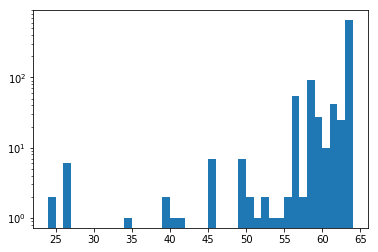

In [15]:
plt.yscale('log', nonposy='clip')
plt.hist(foo,bins=40);